In [40]:
import sqlite3
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


In [41]:
# Path to the SQLite database
sqlite_file = '../data/data.sqlite'

print("Connecting to SQLite database...")
conn = sqlite3.connect(sqlite_file)
print("\n=== Tables in SQLite Database ===")
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(tables_query, conn)
print(tables)


Connecting to SQLite database...

=== Tables in SQLite Database ===
             name
0  quarterly_data
1     annual_data


In [42]:
# Inspecting table schemas and preview data
for table_name in tables['name']:
    print(f"\n=== Schema of Table: {table_name} ===")
    schema_query = f"PRAGMA table_info({table_name});"
    schema = pd.read_sql(schema_query, conn)
    print(schema)

    print(f"\n=== First 5 Rows of Table: {table_name} ===")
    preview_query = f"SELECT * FROM {table_name} LIMIT 5;"
    preview = pd.read_sql(preview_query, conn)
    print(preview)



=== Schema of Table: quarterly_data ===
   cid              name  type  notnull dflt_value  pk
0    0              date  TEXT        0       None   0
1    1  UnemploymentRate  REAL        0       None   0
2    2           GDPRate  REAL        0       None   0

=== First 5 Rows of Table: quarterly_data ===
         date  UnemploymentRate    GDPRate
0  2014-07-01               6.1  18406.941
1  2014-10-01               5.7  18500.031
2  2015-01-01               5.5  18666.621
3  2015-04-01               5.4  18782.243
4  2015-07-01               5.1  18857.418

=== Schema of Table: annual_data ===
   cid              name  type  notnull dflt_value  pk
0    0              date  TEXT        0       None   0
1    1  UnemploymentRate  REAL        0       None   0
2    2           GDPRate  REAL        0       None   0

=== First 5 Rows of Table: annual_data ===
         date  UnemploymentRate    GDPRate
0  1960-01-01               5.5  14001.090
1  1961-01-01               6.7  14360.265
2  

In [43]:
# Load each table from dataset, into a dictionary
data_tables = {}

for table_name in tables['name']:
    query = f"SELECT * FROM {table_name};"
    df = pd.read_sql_query(query, conn)
    
    # Ensure 'date' column is in datetime format
    for col in df.columns:
        if "date" in col.lower():
            df[col] = pd.to_datetime(df[col])

    data_tables[table_name] = df
conn.close()


## EDA


EDA for Table: quarterly_data

Summary statistics:
                                date  UnemploymentRate       GDPRate
count                             41         41.000000     41.000000
mean   2019-07-01 22:14:38.048780544          4.751220  20641.702537
min              2014-07-01 00:00:00          3.500000  18406.941000
25%              2017-01-01 00:00:00          3.800000  19304.352000
50%              2019-07-01 00:00:00          4.200000  20548.793000
75%              2022-01-01 00:00:00          5.100000  21919.222000
max              2024-07-01 00:00:00         13.000000  23400.294000
std                              NaN          1.716264   1484.353886


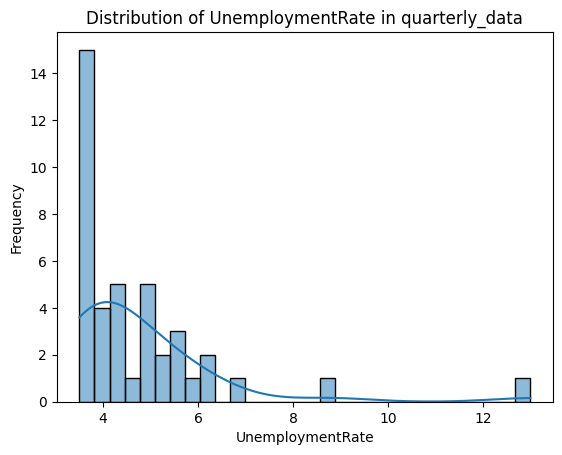

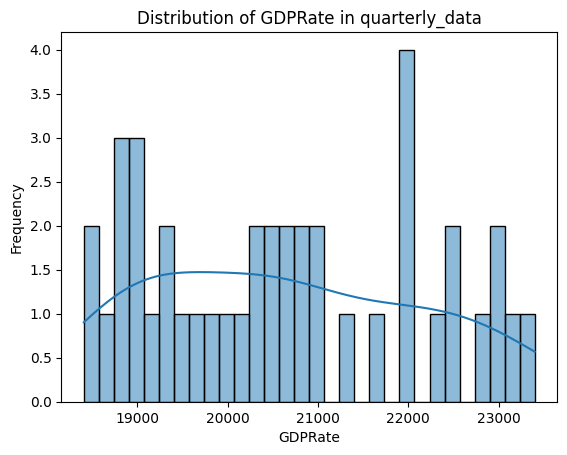


Correlations between numeric columns:
                  UnemploymentRate   GDPRate
UnemploymentRate          1.000000 -0.394853
GDPRate                  -0.394853  1.000000


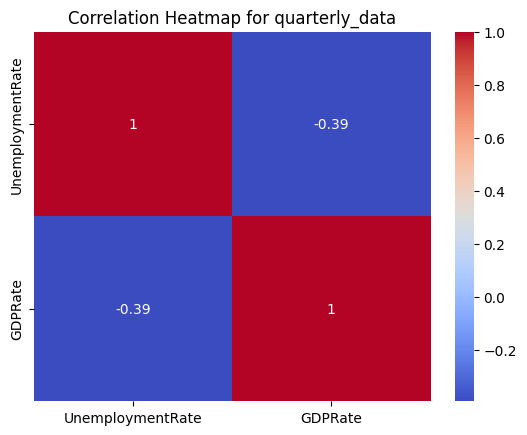


EDA for Table: annual_data

Summary statistics:
                      date  UnemploymentRate       GDPRate
count                   64         64.000000     64.000000
mean   1991-07-02 18:00:00          5.923438  45736.325500
min    1960-01-01 00:00:00          3.500000  14001.090000
25%    1975-10-01 18:00:00          4.850000  25268.680000
50%    1991-07-02 12:00:00          5.600000  40906.349500
75%    2007-04-02 06:00:00          7.025000  66061.888000
max    2023-01-01 00:00:00          9.700000  90684.386000
std                    NaN          1.619400  22634.390824


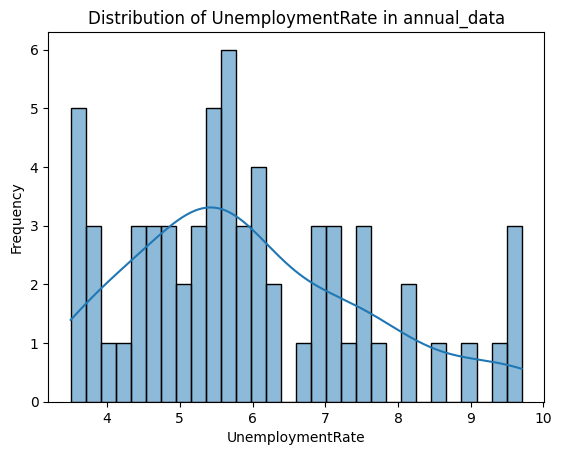

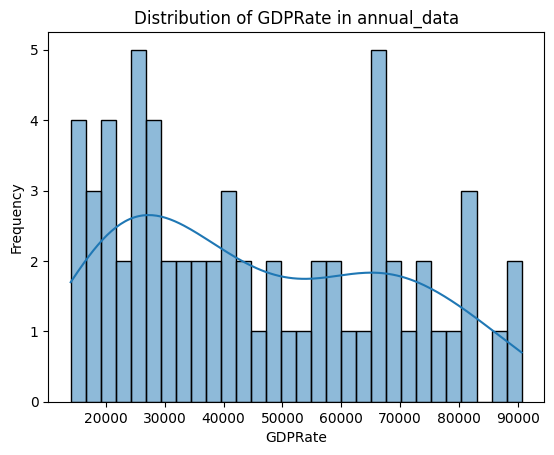


Correlations between numeric columns:
                  UnemploymentRate   GDPRate
UnemploymentRate          1.000000 -0.092677
GDPRate                  -0.092677  1.000000


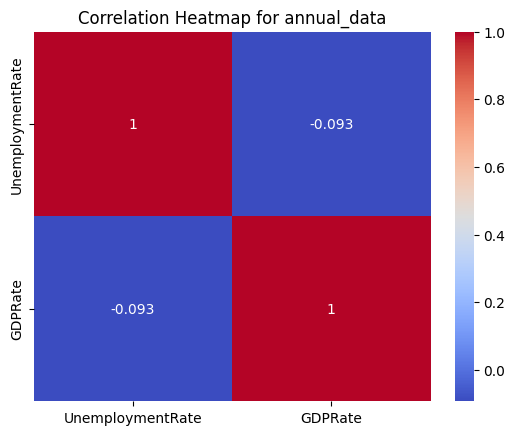

In [44]:
# EDA
for table_name, df in data_tables.items():
    print(f"\nEDA for Table: {table_name}")

    # Summary
    print("\nSummary statistics:")
    print(df.describe())

    # Plot distributions for numeric columns
    for col in df.select_dtypes(include=['float', 'int']):
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"Distribution of {col} in {table_name}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

    # Correlation analysis
    numeric_df = df.select_dtypes(include=['float', 'int'])
    if not numeric_df.empty:
        print("\nCorrelations between numeric columns:")
        corr = numeric_df.corr()
        print(corr)
        sns.heatmap(corr, annot=True, cmap='coolwarm')
        plt.title(f"Correlation Heatmap for {table_name}")
        plt.show()



Time-Series Analysis for Table: quarterly_data


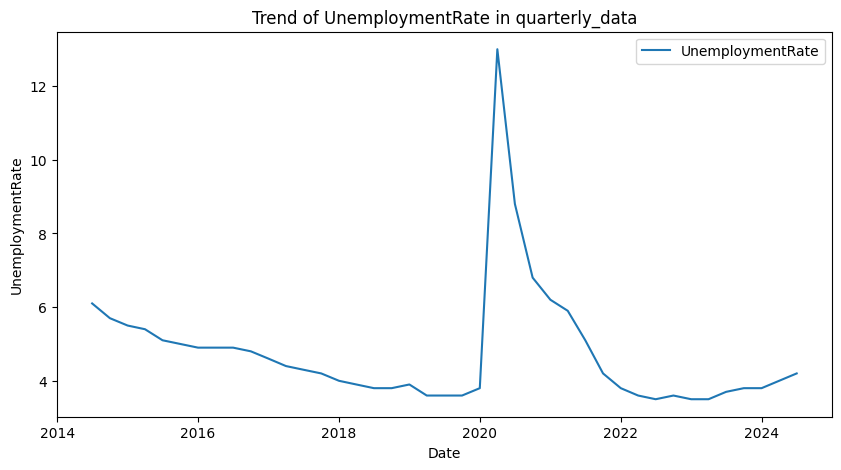

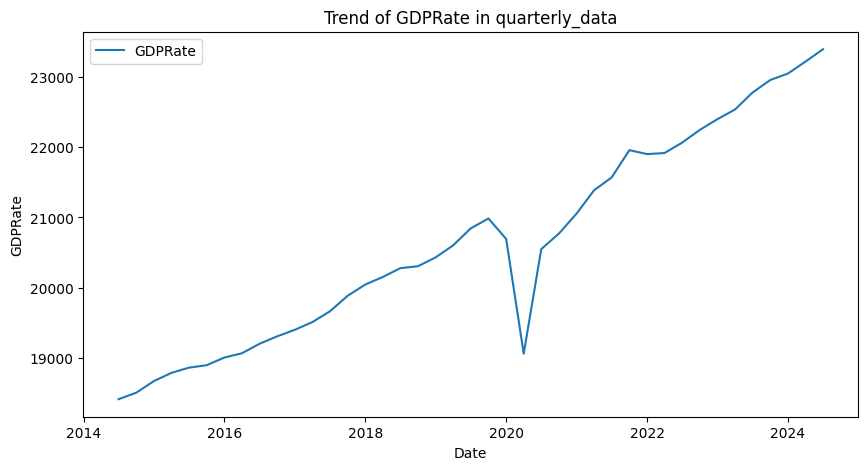


Time-Series Analysis for Table: annual_data


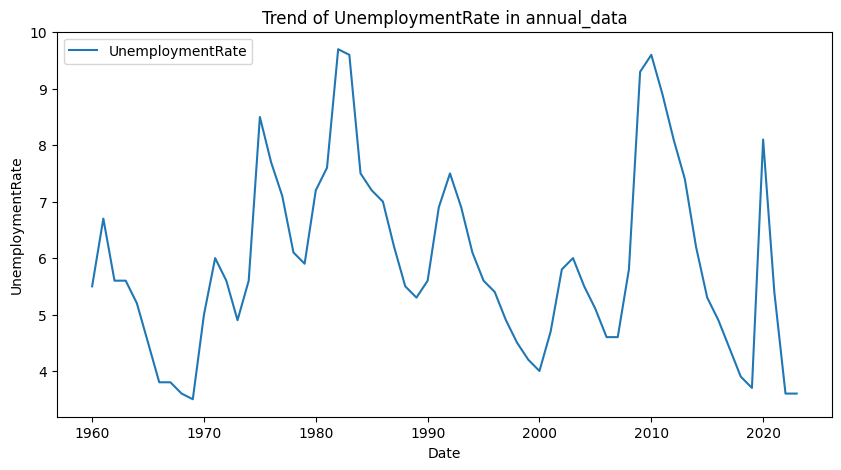

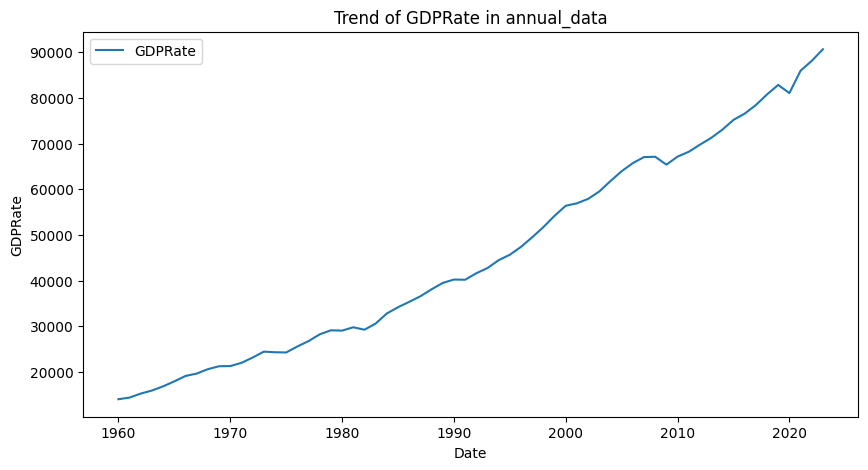

In [45]:
# Time-Series Analysis
for table_name, df in data_tables.items():
    print(f"\nTime-Series Analysis for Table: {table_name}")

    for col in df.columns:
        if "date" in col:
            df.set_index(col, inplace=True)
            numeric_cols = df.select_dtypes(include=['float', 'int']).columns
            for num_col in numeric_cols:
                plt.figure(figsize=(10, 5))
                plt.plot(df.index, df[num_col], label=num_col)
                plt.title(f"Trend of {num_col} in {table_name}")
                plt.xlabel("Date")
                plt.ylabel(num_col)
                plt.legend()
                plt.show()


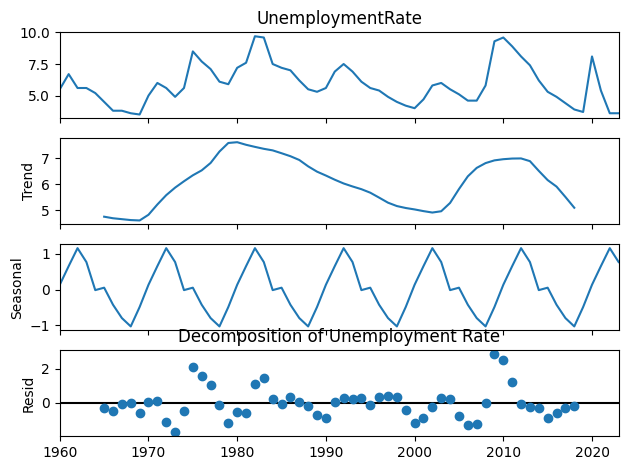

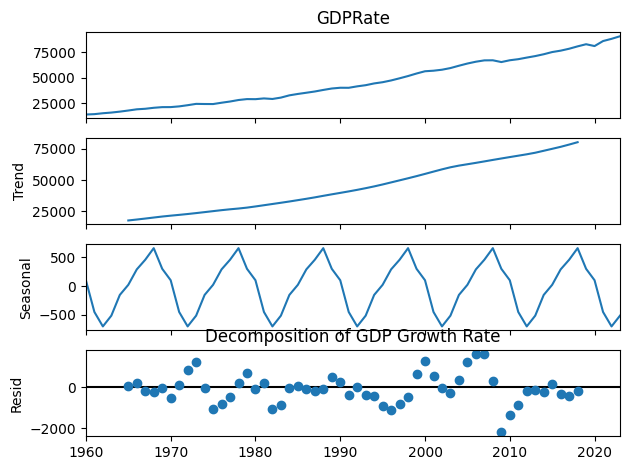

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose unemployment rate and GDP rate
unemployment_decomposition = seasonal_decompose(df['UnemploymentRate'], model='additive', period=10)
gdp_decomposition = seasonal_decompose(df['GDPRate'], model='additive', period=10)

unemployment_decomposition.plot()
plt.title("Decomposition of Unemployment Rate")
plt.show()
gdp_decomposition.plot()
plt.title("Decomposition of GDP Growth Rate")
plt.show()


Pearson Correlation Coefficient: -0.09


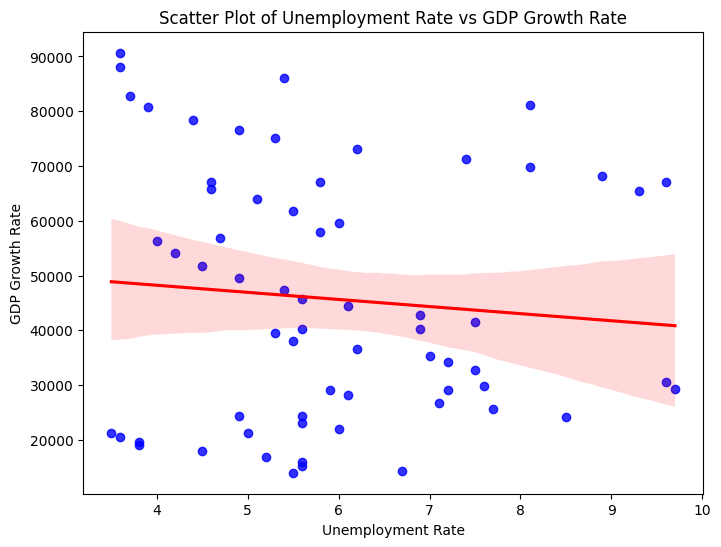

In [57]:
import seaborn as sns
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient
correlation, _ = pearsonr(df['UnemploymentRate'], df['GDPRate'])
print(f"Pearson Correlation Coefficient: {correlation:.2f}")
plt.figure(figsize=(8, 6))
sns.regplot(x='UnemploymentRate', y='GDPRate', data=df, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title("Scatter Plot of Unemployment Rate vs GDP Growth Rate")
plt.xlabel("Unemployment Rate")
plt.ylabel("GDP Growth Rate")
plt.show()
